Epoch 1 | Loss: 14.621642112731934 | Training Accuracy: 0.05078125
Epoch 11 | Loss: 2.596425771713257 | Training Accuracy: 0.34765625
Epoch 21 | Loss: 2.2317333221435547 | Training Accuracy: 0.65625
Epoch 31 | Loss: 2.148380994796753 | Training Accuracy: 0.6953125
Epoch 41 | Loss: 2.0797784328460693 | Training Accuracy: 0.71484375
Epoch 51 | Loss: 2.054518938064575 | Training Accuracy: 0.73828125
Epoch 61 | Loss: 2.023475408554077 | Training Accuracy: 0.7578125
Epoch 71 | Loss: 1.992314100265503 | Training Accuracy: 0.77734375
Epoch 81 | Loss: 1.9526424407958984 | Training Accuracy: 0.828125
Epoch 91 | Loss: 1.9590110778808594 | Training Accuracy: 0.78125
Test Accuracy: 68.31%


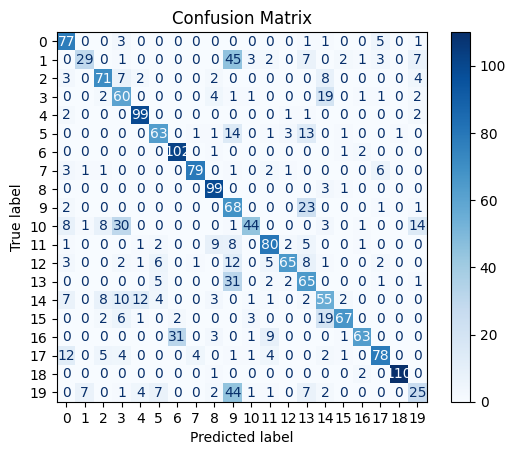

In [2]:
import torch
import snntorch
import tonic
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from collections import namedtuple
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


device = torch.device("mps" if torch.cuda.is_available() else "cpu")

SAMPLE_T = 128  # Time steps per sample
SHD_TIMESTEP = 1e-6  # Time step of SHD dataset
SHD_CHANNELS = 700  # Number of input channels in the SHD dataset
NET_CHANNELS = 128  # Number of input channels in the network
NET_DT = 1 / SAMPLE_T  # Time step for network
BATCH_SIZE = 256  # Batch size
NUM_EPOCHS = 100  # Increased number of epochs
NUM_HIDDEN = 128  # Increased number of hidden units

# Set the input and output shapes
OBS_SHAPE = (NET_CHANNELS,)
ACT_SHAPE = (20,)

from datetime import datetime

# Set up TensorBoard  
run_name = f"SNN_4_lif_hidden_{NUM_HIDDEN}_epochs_{NUM_EPOCHS}"
writer = SummaryWriter(log_dir=f"runs/{run_name}")

class _SHD2Raster:
    """Helper for rasterizing SHD samples into frames."""
    def __init__(self, encoding_dim, sample_T=100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        tensor = np.zeros((events["t"].max() + 1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        tensor = tensor[:self.sample_T, :]
        tensor = np.minimum(tensor, 1)
        return tensor


transform = transforms.Compose([
    transforms.Downsample(time_factor=SHD_TIMESTEP / NET_DT, spatial_factor=NET_CHANNELS / SHD_CHANNELS),
    _SHD2Raster(NET_CHANNELS, sample_T=SAMPLE_T)
])

train_dataset = datasets.SHD("../data", train=True, transform=transform)
test_dataset = datasets.SHD("../data", train=False, transform=transform)


def shuffle(dataset):
    x, y = dataset
    cutoff = y.shape[0] % BATCH_SIZE
    indices = torch.randperm(y.shape[0])[:-cutoff]
    x, y = x[indices], y[indices]
    x = torch.reshape(x, (-1, BATCH_SIZE) + x.shape[1:])
    y = torch.reshape(y, (-1, BATCH_SIZE))
    return namedtuple("State", "obs labels")(x, y)

train_dl = iter(DataLoader(train_dataset, batch_size=len(train_dataset),
                           collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_train, y_train = next(train_dl)
x_train, y_train = x_train.to(torch.uint8), y_train.to(torch.uint8)
x_train, y_train = x_train.to(device), y_train.to(device)

test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))
x_test, y_test = next(test_dl)
x_test, y_test = x_test.to(torch.uint8), y_test.to(torch.uint8)
x_test, y_test = x_test.to(device), y_test.to(device)
x_test, y_test = shuffle((x_test, y_test))

class SNNModel(torch.nn.Module):
    def __init__(self, num_hidden=NUM_HIDDEN, output_size=20):
        super(SNNModel, self).__init__()
        
        self.fc1 = torch.nn.Linear(NET_CHANNELS, num_hidden)
        self.lif1 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)
        
        self.fc2 = torch.nn.Linear(num_hidden, num_hidden)
        self.lif2 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)
        
        self.fc3 = torch.nn.Linear(num_hidden, num_hidden)
        self.lif3 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)
        
        self.fc4 = torch.nn.Linear(num_hidden, output_size)
        self.lif4 = snntorch.Leaky(beta=torch.ones(output_size) * 0.5, learn_beta=True, reset_mechanism="none")

    def forward(self, x):
        x = x.float()
        x = x.permute(1, 0, 2)
        
        mem1, mem2, mem3, mem4 = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif3.init_leaky(), self.lif4.init_leaky()
        spikes = []

        for step in x:
            cur1 = self.fc1(step)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            spikes.append(mem4)

        return torch.stack(spikes, axis=0).permute(1, 0, 2)

model = SNNModel(num_hidden=NUM_HIDDEN).to(device)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

def accuracy(predictions, targets):
    return (torch.argmax(predictions, axis=-1) == targets).sum().item() / len(targets)

# train loop and logging
for epoch in range(NUM_EPOCHS):
    model.train()
    train_batch = shuffle((x_train, y_train))
    train_data, targets = train_batch

    for data, target in zip(train_data, targets):
        optimizer.zero_grad()
        out_V = model(data)
        loss_val = loss_fn(torch.sum(out_V, axis=-2), target)
        loss_val.backward()
        optimizer.step()

    scheduler.step()
    train_acc = accuracy(torch.sum(out_V, axis=-2), target)
    writer.add_scalar("Loss/train", loss_val.item(), epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss_val.item()} | Training Accuracy: {train_acc}")

# Evaluation and Confusion Matrix
def evaluate(model, x_test, y_test):
    model.eval()
    test_acc = []
    all_preds, all_targets = [], []
    with torch.no_grad():
        for test_data, test_targets in zip(x_test, y_test):
            out_V = model(test_data)
            test_acc.append(accuracy(torch.sum(out_V, axis=-2), test_targets))
            all_preds.append(torch.argmax(torch.sum(out_V, axis=-2), axis=-1))
            all_targets.append(test_targets)

    avg_test_acc = np.mean(test_acc)
    all_preds, all_targets = torch.cat(all_preds), torch.cat(all_targets)
    cm = confusion_matrix(all_targets.cpu(), all_preds.cpu())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[str(i) for i in range(20)])
    
    return avg_test_acc, cm_display

# visualise results
test_acc, cm_display = evaluate(model, x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

writer.close()
